### imports

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite
import pickle
import math



### Load five stars review data

In [89]:
electronics_data = pd.read_csv("./ratings_electronics.csv", names=['userId', 'productId', 'rating', 'timestamp'])
# Eliminar la columna 'timestamp' de los datos
electronics_data.drop(['timestamp'], axis=1,inplace=True)
five_star_reviews = electronics_data[electronics_data['rating'] == 5.0]
five_star_reviews.head()


,userId,productId,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
5,A1QGNMC6O1VW39,0511189877,5.0
7,A2TY0BTJOTENPG,0511189877,5.0
8,A34ATBPOK6HCHY,0511189877,5.0


### Create bipartite graph

In [90]:
user_ids = set(five_star_reviews['userId'])
product_ids = set(five_star_reviews['productId'])

# Crear el grafo bipartito
B = nx.from_pandas_edgelist(five_star_reviews, 'userId', 'productId', edge_attr=None, create_using=None)

# Assign label to nodes
for node in B.nodes():
    if node in user_ids:
        B.nodes[node]['bipartite'] = 'users'
    else:
        B.nodes[node]['bipartite'] = 'products'


### Create product projection

On my machine (M1 Pro, 32GB) it takes around 5 mins to run.\
If you want to save your time then just read the projection from the pickle file.

In [91]:
import os
read_from_pickle = True
file_exists = os.path.isfile('user_projection.pickle')
if read_from_pickle and file_exists:
  with open('product_projection.pickle', 'rb') as handle:
    product_projection = pickle.load(handle)
else:
  product_projection = nx.bipartite.weighted_projected_graph(B, product_ids)
  with open('product_projection.pickle', 'wb') as handle:
    pickle.dump(product_projection, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Relevant functions for obtaining neighbor weights

In [92]:
def get_sorted_neighbors_by_weight(graph, node):
    neighbors = graph.neighbors(node)
    neighbors_with_weight = [(neighbor, graph[node][neighbor]['weight']) for neighbor in neighbors]
    neighbors_with_weight = sorted(neighbors_with_weight, key=lambda x: x[1], reverse=True)
    return neighbors_with_weight

def get_top_neighbors(graph, node, limit=10):
    neighbors_with_weight = get_sorted_neighbors_by_weight(graph, node)
    return dict(neighbors_with_weight[:limit])


### Test with the products drawn on the homework description

In [93]:
print("B00ELRTZ5Y")
neighbor_weights = get_top_neighbors(product_projection, "B00ELRTZ5Y", 5)
for neighbor, weight in neighbor_weights.items():
    print(f"Neighbor: {neighbor}, Weight: {weight}")
print("==========================================")
print("B004SD22PQ")
neighbor_weights = get_top_neighbors(product_projection, "B004SD22PQ", 5)
for neighbor, weight in neighbor_weights.items():
    print(f"Neighbor: {neighbor}, Weight: {weight}")
print("==========================================")
print("B005Y586QQ")
neighbor_weights = get_top_neighbors(product_projection, "B005Y586QQ", 5)
for neighbor, weight in neighbor_weights.items():
    print(f"Neighbor: {neighbor}, Weight: {weight}")





B00ELRTZ5Y
Neighbor: B0088LYCZC, Weight: 2
Neighbor: B000EP4TWQ, Weight: 1
Neighbor: B003YK4798, Weight: 1
Neighbor: B006YLYYZ6, Weight: 1
Neighbor: B00B7YBE9E, Weight: 1
B004SD22PQ
Neighbor: B005DOK8NW, Weight: 30
Neighbor: B007R5YDYA, Weight: 7
Neighbor: B004JWA70I, Weight: 4
Neighbor: B003ELYQGG, Weight: 4
Neighbor: B0074BW614, Weight: 4
B005Y586QQ
Neighbor: B007P4VOWC, Weight: 7
Neighbor: B005N130Y4, Weight: 5
Neighbor: B007TYUTY2, Weight: 4
Neighbor: B008MPVUK4, Weight: 3
Neighbor: B007M506WS, Weight: 3


### Drawing functions

In [94]:

def reduce_magnitude(vector):
    (x, y) = vector
    magnitude = math.sqrt(x**2 + y**2)
    unit_vector = (x / magnitude, y / magnitude)
    desired_magnitude = 0.5 * magnitude
    return (unit_vector[0] * desired_magnitude, unit_vector[1] * desired_magnitude)

def get_edge_color(edge, selected_node, top_neighbors = []):
    color = 'black'
    if edge[0] != selected_node and edge[1] != selected_node:
       color = 'white'
    if edge[0] in top_neighbors or edge[1] in top_neighbors :
        color = 'red'
    return color


def draw_recommendation_graph(selected_node, limit, highlight_limit):
    sorted_neighbors = get_sorted_neighbors_by_weight(product_projection, selected_node)
    top_neighbors = get_top_neighbors(product_projection, selected_node, highlight_limit).keys()

    # Extract neighbors and widths from sorted_neighbors
    neighbors, widths = map(list, zip(*sorted_neighbors[:limit]))

    # Create subgraph nodes including the selected node and its neighbors
    subgraph_nodes = [selected_node, *neighbors]

    # Get positions for the graph visualization
    star_graph = nx.star_graph(subgraph_nodes)
    pos = nx.circular_layout(star_graph)
    pos[selected_node] = [0.00001, 0.00001]
    new_positions = {node: reduce_magnitude(vector) for node, vector in pos.items()}

    # Set node colors, edge colors, and edge labels
    node_colors = ['green' if node == selected_node else 'skyblue' for node in star_graph.nodes()]
    edge_colors = [get_edge_color(edge, selected_node, top_neighbors) for edge in star_graph.edges()]
    edge_labels = {pair[0]: pair[1] for pair in sorted_neighbors[:limit]}

    # Draw the graph
    nx.draw(star_graph, pos=pos, with_labels=True, node_color=node_colors, width=widths, node_size=1000, edge_color=edge_colors)
    nx.draw_networkx_labels(star_graph, new_positions, labels=edge_labels, bbox=dict(facecolor="white"))





### Draw the 3 examples

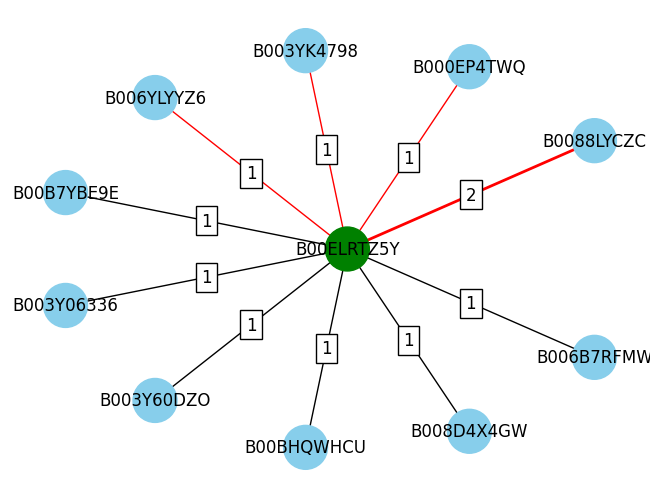

In [95]:
draw_recommendation_graph("B00ELRTZ5Y", 10, 4)


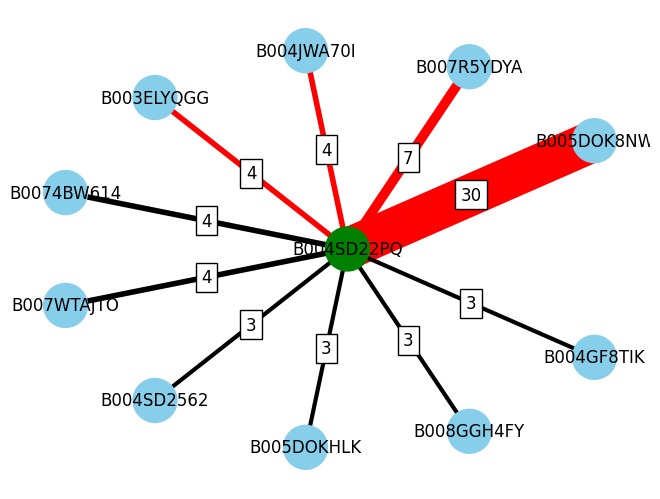

In [96]:
draw_recommendation_graph("B004SD22PQ", 10, 4)


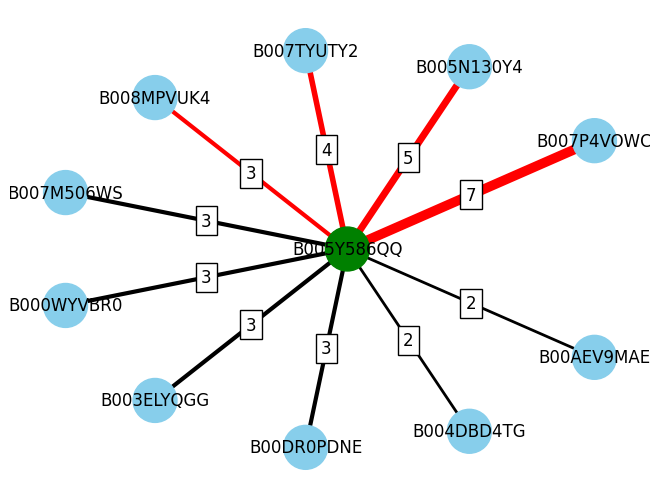

In [97]:
draw_recommendation_graph("B005Y586QQ", 10, 4)
